In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from matplotlib import dates
import matplotlib.pyplot as plt
import time
from pathlib import Path
from tables import open_file
#
#
import ROOT as ROOT
import ctypes

%matplotlib inline

Welcome to JupyROOT 6.28/12


In [2]:
# Import hard DAMPE spectrum (0.1 - 6.3 TeV) for Protons
def DAMPE_proton_hard(energy, ekin_cutoff_min=0.01, ekin_cutoff_max=6.3):
    cutoff=np.int64(energy<ekin_cutoff_max)
    cutoff=cutoff*np.int64(energy>=ekin_cutoff_min)
    result = (0.0758*np.power(energy, -2.772) * np.power((1 + np.power((energy/0.48),5.0)), 0.0346))*cutoff
    return result

# Import soft DAMPE spectrum (6.3 - 100 TeV) for Protons
def DAMPE_proton_soft(energy, ekin_cutoff_min=6.3, ekin_cutoff_max=100):
    cutoff=np.int64(energy<ekin_cutoff_max)
    cutoff=cutoff*np.int64(energy>=ekin_cutoff_min)
    result = (0.0868*np.power(energy, -2.6) * np.power((1 + np.power((energy/13.6),5.0)), -0.05))*cutoff
    return result

# Import soft DAMPE spectrum (6.3 - 100 TeV) for Protons
def DAMPE_proton(energy):
    return DAMPE_proton_hard(energy) + DAMPE_proton_soft(energy)

def get_solid_angle(thetaDeg):
  return 2*np.pi*(1.0-np.cos(thetaDeg/180.0*np.pi))

def get_integral( ekin, rate_per_TeV, eMin_TeV, eMax_TeV, n_integral_points = 1000000):
    xx=np.linspace(eMin_TeV,eMax_TeV,n_integral_points)
    dx=xx[1]-xx[0]
    yy=np.interp(xx, ekin, rate_per_TeV)
    return np.sum(yy)*dx

In [3]:
def get_proton_rate( sim, trg, Rsim_m=1500, thetaSim_deg=10):
    ekin_min = 0.01  #TeV
    ekin_max = 100.0 #TeV
    n_log_bins = 100
    bins=np.logspace(np.log10(ekin_min),np.log10(ekin_max),n_log_bins)
    hist_sim=plt.hist( sim, bins=bins);
    hist_trg=plt.hist( trg, bins=bins);
    #
    energy_bins = (hist_sim[1][:-1] + hist_sim[1][1:])/2.0;
    nev_sim=hist_sim[0]
    nev_trg=hist_trg[0]
    #
    ekin=energy_bins
    rate_per_TeV_per_s=DAMPE_proton(ekin)*nev_trg/nev_sim*np.pi*Rsim_m*Rsim_m*get_solid_angle(thetaSim_deg)
    #
    proton_rate = get_integral( ekin, rate_per_TeV_per_s, ekin_min, ekin_max)
    #
    del(hist_sim)
    del(hist_trg)
    plt.close()
    #
    return proton_rate

In [55]:
def get_L1_DCR_tare( L1_max_digi_sum, dt_sim_s, threshold):
    time_tot_s = len(L1_max_digi_sum)*dt_sim_s
    return np.sum(np.int64(L1_max_digi_sum>threshold))/time_tot_s

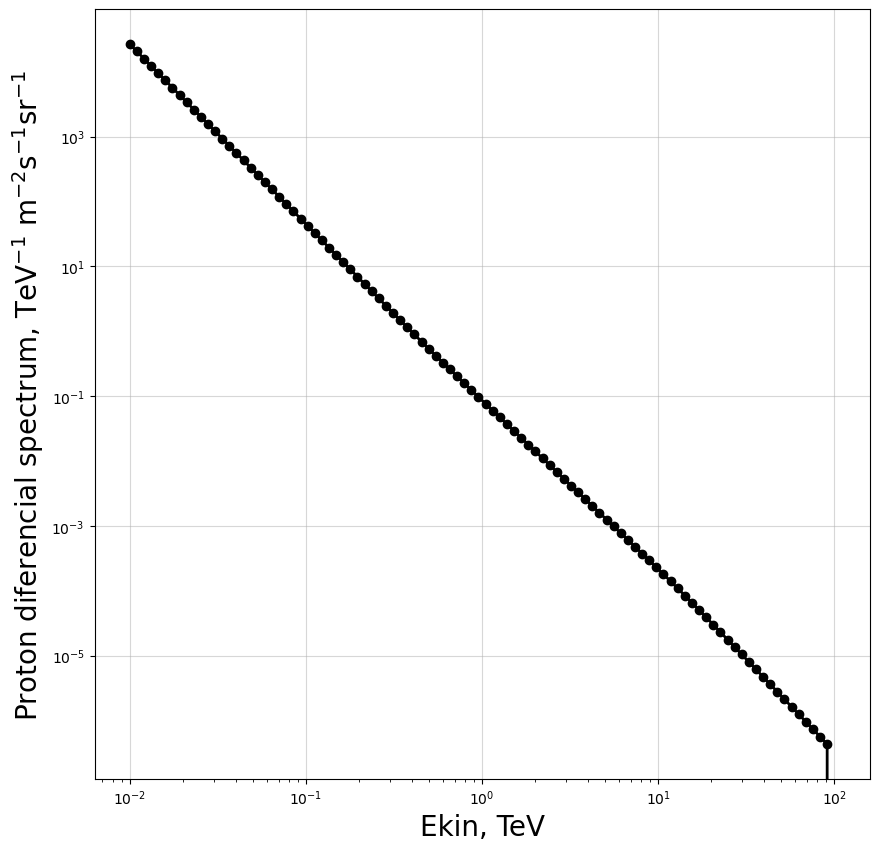

In [4]:
fig, ax = plt.subplots(figsize=(10,10))

thefontsize=20

ax.set_ylabel('Proton diferencial spectrum, TeV$^{-1}$ m$^{-2}$s$^{-1}$sr$^{-1}$',fontsize=thefontsize)
ax.set_xlabel('Ekin, TeV',fontsize=thefontsize)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(-4,6);
#ax.set_ylim(-0.000001,0.000001);
#
ax.grid(True,alpha=0.5)
ekin=np.logspace(np.log10(0.01),np.log10(100.0),100)

ax.plot(ekin, 
        DAMPE_proton(ekin),
        lw=2, 
        color='black', 
        marker='o',
        label='data')

In [5]:
ncsvf=!(ls ../scratch/simtel_data/proton/npe/corsika_run*.npe.csv | wc -l)
ncsvf=int((ncsvf[0]))
fname_list=['../scratch/simtel_data/proton/npe/corsika_run' + str(i) + '.npe.csv' for i in range(1,ncsvf+1)]
df_list=[pd.read_csv(fname) for fname in fname_list]
#
df=pd.concat(df_list, ignore_index=True)
n_sim_ev_per_file = 1000000.0
n_sim_ev = len(df_list)*n_sim_ev_per_file
dt_one_wf_ns = 75*1000/1024.0
dt_one_wf_s = dt_one_wf_ns*1.0e-9
#
print("n_sim_ev     = ", n_sim_ev)
print("len(df_list) = ", len(df_list))
print("dt_one_wf_ns = ", dt_one_wf_ns)
print("dt_one_wf_s  = ", dt_one_wf_s)

n_sim_ev     =  426000000.0
len(df_list) =  426
dt_one_wf_ns =  73.2421875
dt_one_wf_s  =  7.324218750000001e-08


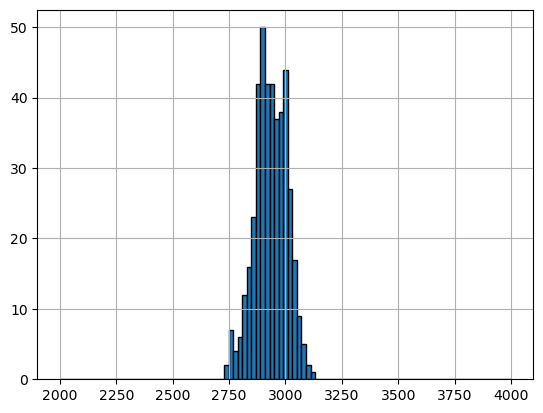

426


In [6]:
plt.hist(np.array([len(dftmp) for dftmp in df_list]), bins=np.linspace(2000.0, 4000, num=100), edgecolor='black', alpha=1.0)
plt.grid(True)
plt.show()
print(len(df_list))

In [52]:
df

,Unnamed: 0,event_id,energy,azimuth,altitude,h_first_int,xmax,hmax,emax,cmax,...,L3_cl_channelID_LST3,L3_cl_timeID_LST3,L3_cl_n_digitalsum_points_LST4,L3_cl_n_clusters_LST4,L3_cl_n_points_LST4,L3_cl_x_mean_LST4,L3_cl_y_mean_LST4,L3_cl_t_mean_LST4,L3_cl_channelID_LST4,L3_cl_timeID_LST4
0,0,5200.0,0.115086,3.062638,1.218684,16199.321289,273.076935,10251.343750,273.333344,278.034241,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,1,5208.0,0.115086,3.062638,1.218684,16199.321289,273.076935,10251.343750,273.333344,278.034241,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,2,5504.0,1.123066,3.220341,1.271500,12663.388672,457.200012,6639.671875,461.428558,460.637756,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,3,6409.0,0.122709,2.996659,1.231897,17323.265625,294.000000,9758.931641,294.000000,328.353088,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,4,7604.0,0.230914,3.106559,1.238464,13307.477539,516.086975,5728.506348,516.956543,458.041138,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249679,2833,9968301.0,0.655462,3.029138,1.208794,15159.474609,337.500000,8817.290039,334.666656,300.884735,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1249680,2834,9972704.0,2.421454,2.814749,1.269003,31757.238281,231.363632,11332.046875,231.333328,226.344101,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1249681,2835,9973603.0,0.903230,3.182498,1.352516,17908.154297,354.615387,8472.549805,354.000000,357.879913,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1249682,2836,9986905.0,0.249339,3.064357,1.168519,16672.931641,234.000000,11259.129883,233.157898,233.855255,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [8]:
df_20pe_DCR=df[df['n_pe_LST1']==20]
df_min20pe=df[df['n_pe_LST1']>=20]
df_min30pe=df[df['n_pe_LST1']>=30]
df_min40pe=df[df['n_pe_LST1']>=40]
df_min50pe=df[df['n_pe_LST1']>=50]
df_min60pe=df[df['n_pe_LST1']>=60]
df_min70pe=df[df['n_pe_LST1']>=70]
df_min80pe=df[df['n_pe_LST1']>=80]
df_min90pe=df[df['n_pe_LST1']>=90]
df_min100pe=df[df['n_pe_LST1']>=100]
df_min110pe=df[df['n_pe_LST1']>=110]
df_trg_l1=df[df['L1_max_digi_sum_LST1']>14963]
df_trg_l1_20pe_DCR=df_20pe_DCR[df_20pe_DCR['L1_max_digi_sum_LST1']>14963]
df_trg_l2=df_trg_l1[df_trg_l1['L3_iso_n_points_LST1']>7]
df_trg_l2_20pe_DCR=df_trg_l1_20pe_DCR[df_trg_l1_20pe_DCR['L3_iso_n_points_LST1']>7]

In [9]:
sim=1.0/np.random.uniform(1.0/100,1.0/0.01,int(n_sim_ev)) 
trg=df_min20pe['energy'].values
print(get_proton_rate( sim, trg))

55611.17289028594


In [10]:
trg=df_min30pe['energy'].values
print(get_proton_rate( sim, trg))

33521.912119850975


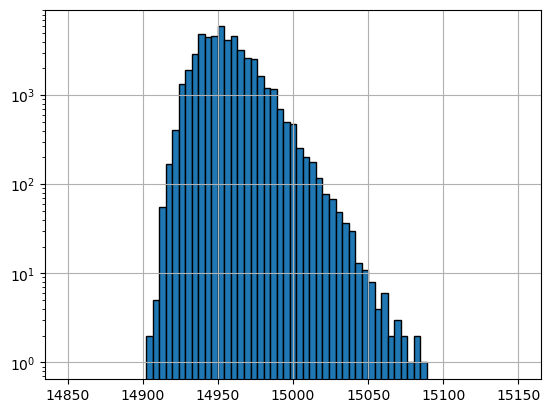

In [11]:
plt.hist(df_20pe_DCR['L1_max_digi_sum_LST1'].values, bins=np.linspace(14850, 15150, num=70), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

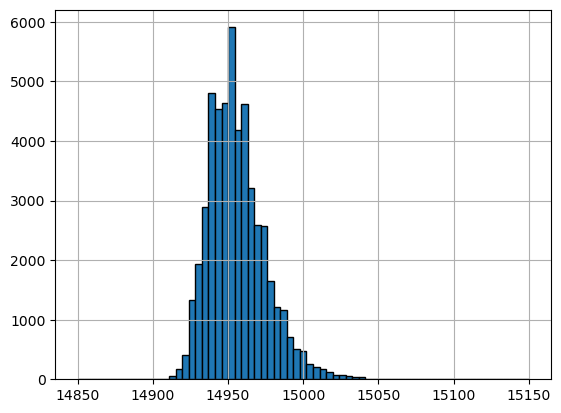

In [75]:
plt.hist(df_20pe_DCR['L1_max_digi_sum_LST1'].values, bins=np.linspace(14850, 15150, num=70), edgecolor='black', alpha=1.0)
#plt.yscale('log')
plt.grid(True)
plt.show()

In [77]:
threshold=np.arange(14800,15100,1)
rate_DCR_L1=[ get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=threshold) for threshold in np.arange(14800,15100,1)]
#get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=15085)

In [84]:
threshold_all=np.arange(14800,15200,1)
rate_DCR_L1_all=[ get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=threshold) + 50000 for threshold in threshold_all]
#get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=15085)

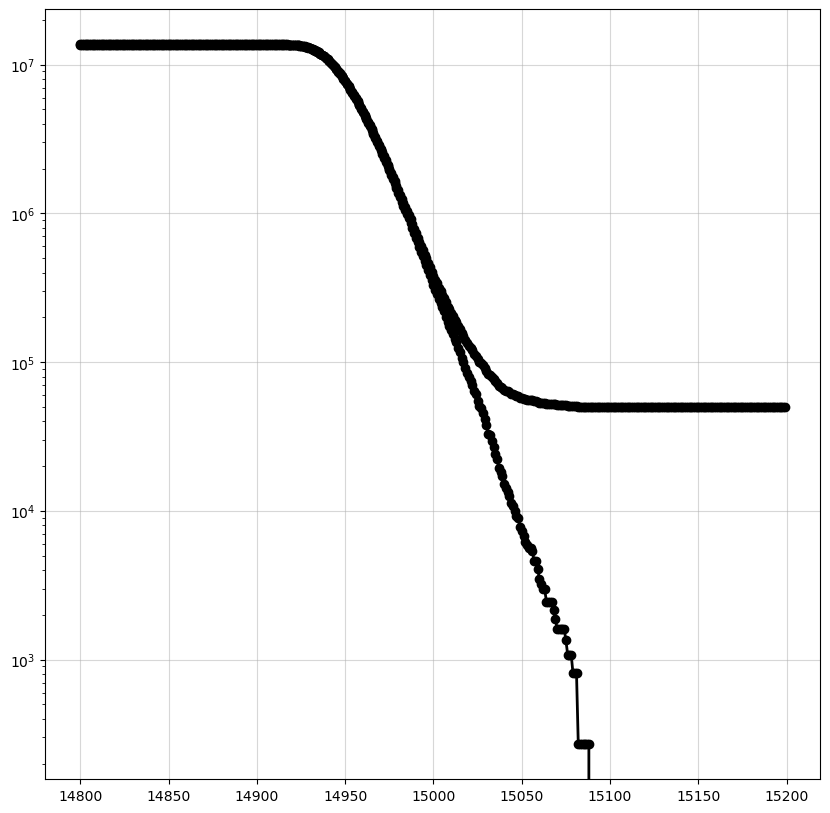

In [85]:
#threshold=np.arange(14800,15100,1)
#rate_DCR_L1=[ get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=threshold) for threshold in np.arange(14800,15100,1)]
#get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=15085)

fig, ax = plt.subplots(figsize=(10,10))

thefontsize=20

#ax.set_ylabel('Proton rate, TeV$^{-1}$ s$^{-1}$',fontsize=thefontsize)
#ax.set_xlabel('Ekin, TeV',fontsize=thefontsize)
#ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(-4,6);
#ax.set_ylim(-0.000001,0.000001);
#
ax.grid(True,alpha=0.5)
#ekin=df_LSTsipm_protons_sim['energy'].values
#rate_per_TeV_per_s=DAMPE_proton(ekin)*df_LSTsipm_protons_trg110pe['nev'].values/df_LSTsipm_protons_sim['nev'].values*np.pi*1500*1500*get_solid_angle(10)

ax.plot(threshold, 
        rate_DCR_L1,
        lw=2, 
        color='black', 
        marker='o',
        label='data')

ax.plot(threshold_all, 
        rate_DCR_L1_all,
        lw=2, 
        color='black', 
        marker='o',
        label='data')


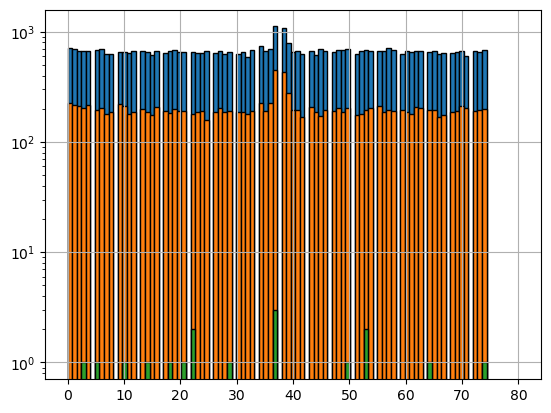

50656
15145


In [12]:
plt.hist(df_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
plt.hist(df_trg_l1_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
plt.hist(df_trg_l2_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()
print(len(df_20pe_DCR['L1_t_mean_LST1']))
print(len(df_trg_l1_20pe_DCR['L1_t_mean_LST1']))

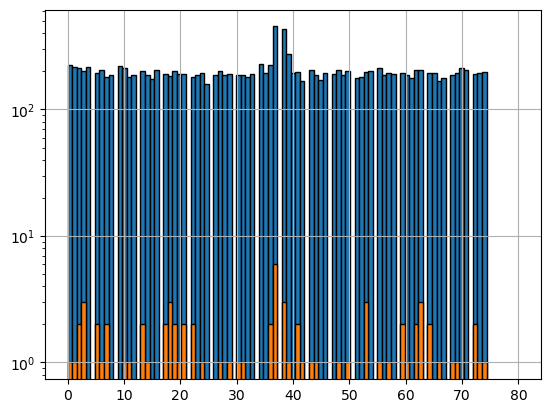

In [36]:
plt.hist(df_trg_l1_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
plt.hist(df_trg_l2_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

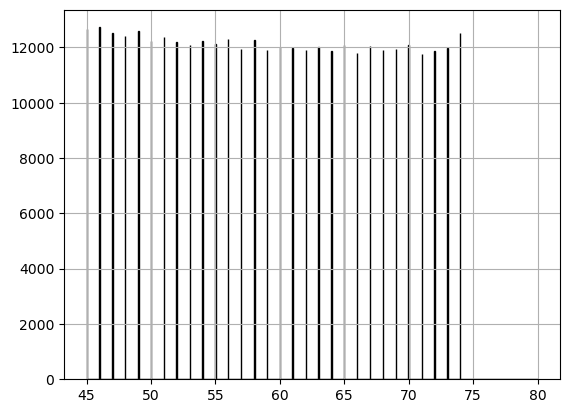

In [32]:
plt.hist(df['L1_t_mean_LST1'].values, bins=np.linspace(45, 80, num=1000), edgecolor='black', alpha=1.0);
#plt.yscale('log')
plt.grid(True)
plt.show()

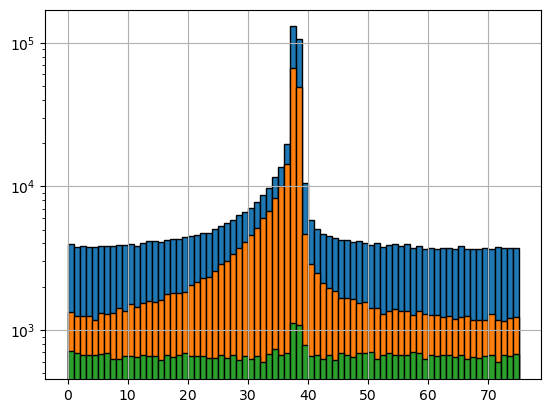

In [48]:
plt.hist(df_trg_l1['L1_t_mean_LST1'].values, bins=np.linspace(0, 75, num=76), edgecolor='black', alpha=1.0)
plt.hist(df_min110pe['L1_t_mean_LST1'].values, bins=np.linspace(0, 75, num=76), edgecolor='black', alpha=1.0)
plt.hist(df_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 75, num=76), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

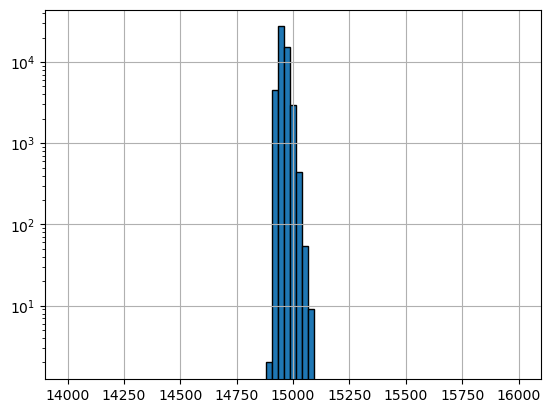

In [51]:
plt.hist(df_20pe_DCR['L1_max_digi_sum_LST1'].values, bins=np.linspace(14000, 16000, num=76), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

In [10]:
#14963 and L3 n points is > 7
df_trg_l1=df[df['L1_max_digi_sum_LST1']>14963]
df_trg_l2=df_trg_l1[df_trg_l1['L3_iso_n_points_LST1']>7]

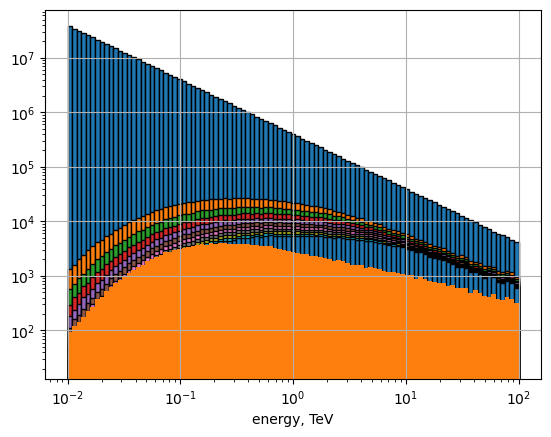

In [12]:
hist_sim=plt.hist(1.0/np.random.uniform(1.0/100,1.0/0.01,int(n_sim_ev)), 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg20pe=plt.hist(df_min20pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg30pe=plt.hist(df_min30pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg40pe=plt.hist(df_min40pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg50pe=plt.hist(df_min50pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg60pe=plt.hist(df_min60pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg70pe=plt.hist(df_min70pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg80pe=plt.hist(df_min80pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg90pe=plt.hist(df_min90pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg100pe=plt.hist(df_min100pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg110pe=plt.hist(df_min110pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
#
hist_trg=plt.hist(df_trg_l2['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), alpha=1.0)
#
plt.xlabel('energy, TeV')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

In [13]:
df_LSTsipm_protons_sim = pd.DataFrame({
    'energy': (hist_sim[1][:-1] + hist_sim[1][1:])/2.0,
    'nev': hist_sim[0]
})
df_LSTsipm_protons_trg = pd.DataFrame({
    'energy': (hist_trg[1][:-1] + hist_trg[1][1:])/2.0,
    'nev': hist_trg[0]
})
#
df_LSTsipm_protons_trg20pe = pd.DataFrame({
    'energy': (hist_trg20pe[1][:-1] + hist_trg20pe[1][1:])/2.0,
    'nev': hist_trg20pe[0]
})
df_LSTsipm_protons_trg30pe = pd.DataFrame({
    'energy': (hist_trg30pe[1][:-1] + hist_trg30pe[1][1:])/2.0,
    'nev': hist_trg30pe[0]
})
df_LSTsipm_protons_trg40pe = pd.DataFrame({
    'energy': (hist_trg40pe[1][:-1] + hist_trg40pe[1][1:])/2.0,
    'nev': hist_trg40pe[0]
})
df_LSTsipm_protons_trg50pe = pd.DataFrame({
    'energy': (hist_trg50pe[1][:-1] + hist_trg50pe[1][1:])/2.0,
    'nev': hist_trg50pe[0]
})
df_LSTsipm_protons_trg60pe = pd.DataFrame({
    'energy': (hist_trg60pe[1][:-1] + hist_trg60pe[1][1:])/2.0,
    'nev': hist_trg60pe[0]
})
df_LSTsipm_protons_trg70pe = pd.DataFrame({
    'energy': (hist_trg70pe[1][:-1] + hist_trg70pe[1][1:])/2.0,
    'nev': hist_trg70pe[0]
})
df_LSTsipm_protons_trg80pe = pd.DataFrame({
    'energy': (hist_trg80pe[1][:-1] + hist_trg80pe[1][1:])/2.0,
    'nev': hist_trg80pe[0]
})
df_LSTsipm_protons_trg90pe = pd.DataFrame({
    'energy': (hist_trg90pe[1][:-1] + hist_trg90pe[1][1:])/2.0,
    'nev': hist_trg90pe[0]
})
df_LSTsipm_protons_trg100pe = pd.DataFrame({
    'energy': (hist_trg100pe[1][:-1] + hist_trg100pe[1][1:])/2.0,
    'nev': hist_trg100pe[0]
})
df_LSTsipm_protons_trg110pe = pd.DataFrame({
    'energy': (hist_trg110pe[1][:-1] + hist_trg110pe[1][1:])/2.0,
    'nev': hist_trg110pe[0]
})
#
#
#df_LSTsipm_protons_sim.to_csv('LST_AdvCam_Zenith_20.00deg_proton_sim.csv', index=False, header=False, sep=' ')
#df_LSTsipm_protons_trg.to_csv('LST_AdvCam_Zenith_20.00deg_proton_trg.csv', index=False, header=False, sep=' ')
#df_LSTsipm_protons_trg['nev'].values/df_LSTsipm_protons_sim['nev'].values

6556.912911872947


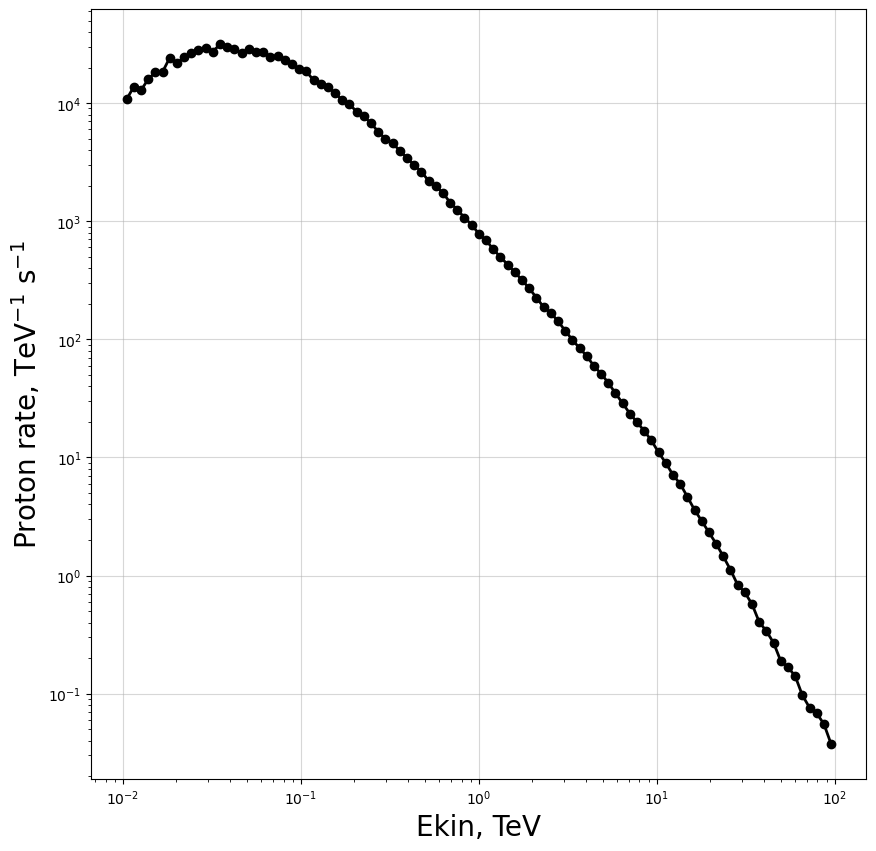

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

thefontsize=20

ax.set_ylabel('Proton rate, TeV$^{-1}$ s$^{-1}$',fontsize=thefontsize)
ax.set_xlabel('Ekin, TeV',fontsize=thefontsize)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(-4,6);
#ax.set_ylim(-0.000001,0.000001);
#
ax.grid(True,alpha=0.5)
ekin=df_LSTsipm_protons_sim['energy'].values
rate_per_TeV_per_s=DAMPE_proton(ekin)*df_LSTsipm_protons_trg110pe['nev'].values/df_LSTsipm_protons_sim['nev'].values*np.pi*1500*1500*get_solid_angle(10)

ax.plot(ekin, 
        rate_per_TeV_per_s,
        lw=2, 
        color='black', 
        marker='o',
        label='data')

print(get_integral( ekin, rate_per_TeV_per_s, 0.01, 100))

#print("nterp ",np.interp([10,20], ekin, rate_per_TeV_per_s))

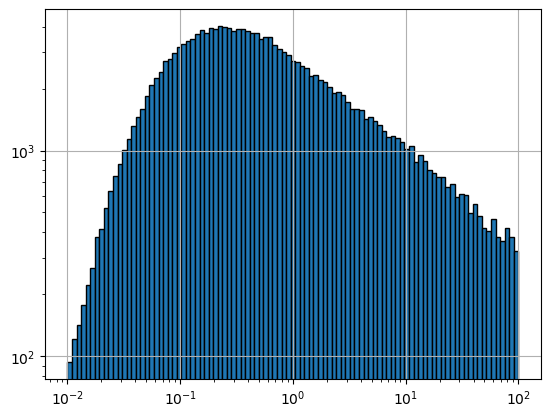

In [26]:
#
hist_trg=plt.hist(df_trg_l2['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
#
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()
#

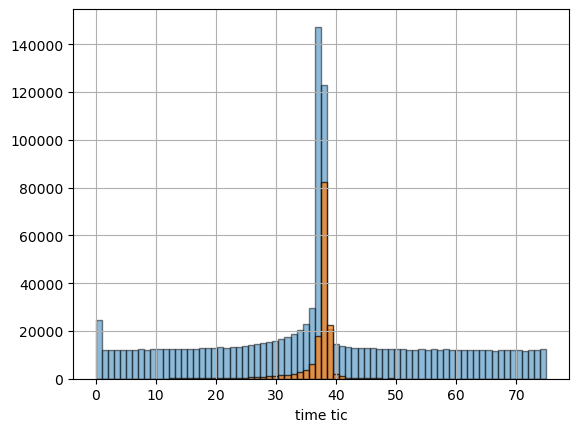

In [27]:
plt.hist(df['L1_t_mean_LST1'].values, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.5)
plt.hist(df_trg_l2['L3_cl_t_mean_LST1'].values*1.0/0.06, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.7)
plt.xlabel('time tic')
#plt.yscale('log')
plt.grid(True)
plt.show()

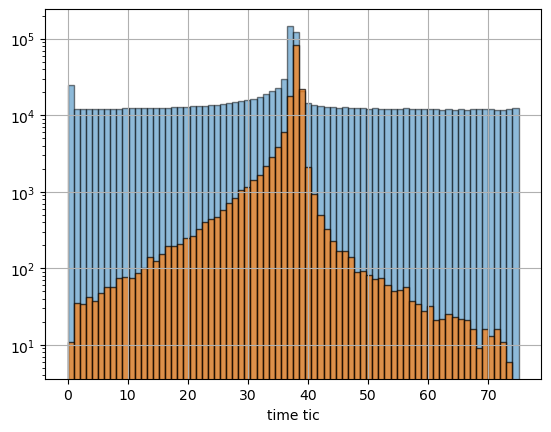

In [28]:
plt.hist(df['L1_t_mean_LST1'].values, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.5)
plt.hist(df_trg_l2['L3_cl_t_mean_LST1'].values*1.0/0.06, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.7)
plt.xlabel('time tic')
plt.yscale('log')
plt.grid(True)
plt.show()

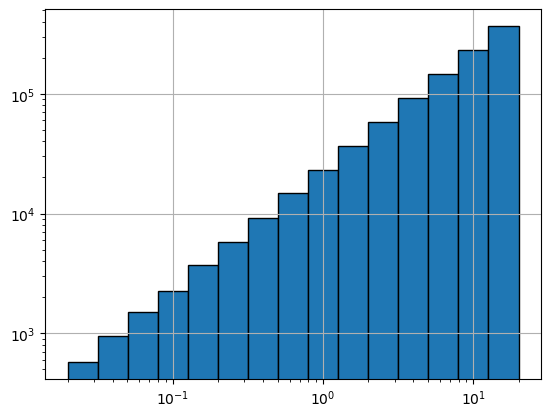

In [29]:
thehist=plt.hist(np.random.uniform(0.02,20,1000000), bins=np.logspace(np.log10(0.02),np.log10(20.0),16), edgecolor='black', alpha=1.0)
#plt.hist(np.random.uniform(0.02,20,10000), bins=np.linspace(0.02,20,16), edgecolor='black', alpha=1.0)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [30]:
thehist

(array([   576.,    943.,   1506.,   2271.,   3714.,   5785.,   9144.,
         14818.,  23303.,  36765.,  58484.,  93101., 146945., 233089.,
        369556.]),
 array([ 0.02      ,  0.03169786,  0.05023773,  0.07962143,  0.12619147,
         0.2       ,  0.31697864,  0.50237729,  0.79621434,  1.26191469,
         2.        ,  3.16978638,  5.02377286,  7.96214341, 12.61914689,
        20.        ]),
 <BarContainer object of 15 artists>)

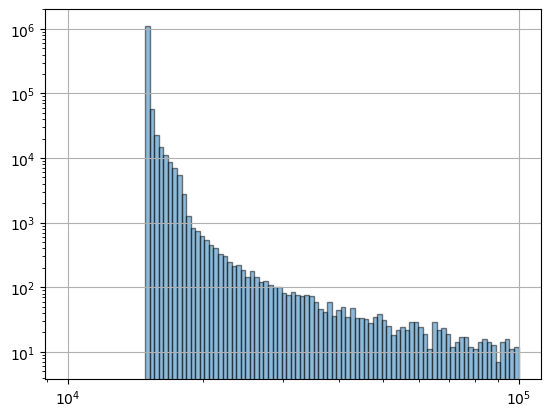

In [31]:
plt.hist(df['L1_max_digi_sum_LST1'].values, bins=np.logspace(np.log10(10000),np.log10(100000.0),100), edgecolor='black', alpha=0.5)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

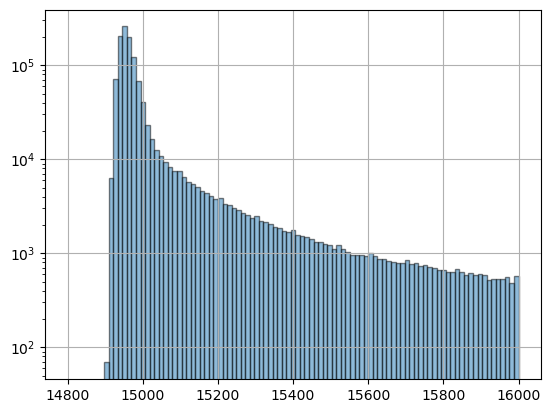

In [32]:
plt.hist(df['L1_max_digi_sum_LST1'].values, bins=np.linspace(14800,16000,100), edgecolor='black', alpha=0.5)
plt.yscale('log')   # Set y-axis to logarithmic scale
#plt.xscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [33]:
len(df['L1_max_digi_sum_LST1'])

1249684

In [34]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])